<a href="https://colab.research.google.com/github/AMAYadav/PROJECTS-/blob/main/APPLE_TIME_SEIRES_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install prophet

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 350, in run
    global_options=[],
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/wheel_builder.py", line 337, in build
    req, cache_dir, verify, build_options, global_options
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/wheel_builder.py", line 224, in _build_one
    req, output_dir, build_options, global_options
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/wheel_builder.py", line 268, in _build_one_inside_env
    tempd=temp_dir.path,
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/operations/buil

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

In [35]:
import yfinance as yf

df = yf.download(tickers='AAPL',period='2y',interval='1d',rounding='3',progress=False)['Adj Close']
df=pd.DataFrame(df)
df.head()
df.tail()

,Adj Close
Date,
2021-11-08,150.44
2021-11-09,150.81
2021-11-10,147.92
2021-11-11,147.87
2021-11-12,149.99


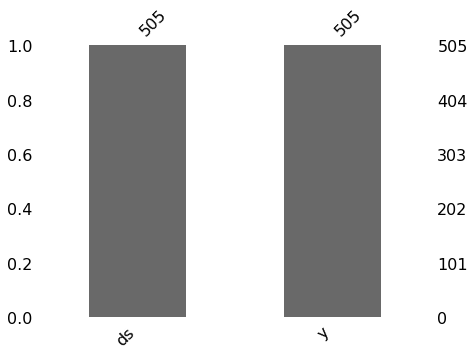

In [63]:
ms.bar(df,figsize=(7,5))

In [5]:
df.isnull().sum()
df.info()
df.describe()
df.shape
df.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2019-11-13 to 2021-11-12
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  505 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


Index(['Adj Close'], dtype='object')

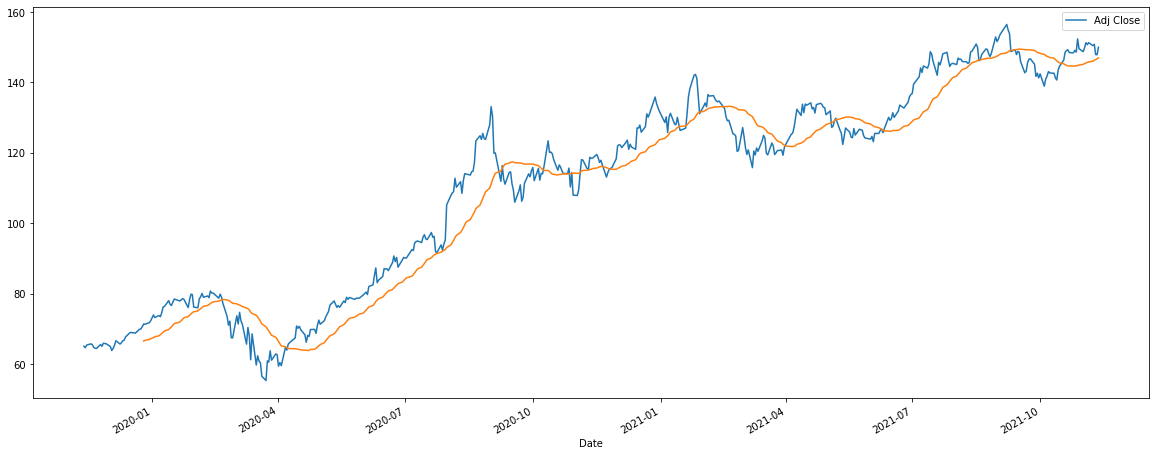

In [31]:
df.plot()
df['Adj Close'].rolling(30).mean().dropna().plot(figsize=(20,8))
plt.savefig('graph.png',dpi=500)

In [38]:
df.reset_index(drop=False,inplace=True)
df.rename(columns={'Date':'ds','Adj Close':'y'},inplace=True)
df.count()

ds    505
y     505
dtype: int64

In [39]:
df_train1= df.loc[:300]
df_test1= df.loc[299:]

In [ ]:
#train_test split
# df_train=df['ds'].apply(lambda x: x.year)<2021
# trainset=df.loc[df_train].dropna()
# testset=df.loc[~df_train].reset_index(drop=True)

In [40]:
from fbprophet import Prophet
m = Prophet()
m.add_seasonality(name='monthly', period=21, fourier_order=5)
m.fit(df_train1) 
future = m.make_future_dataframe(periods=305)
prediction= m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


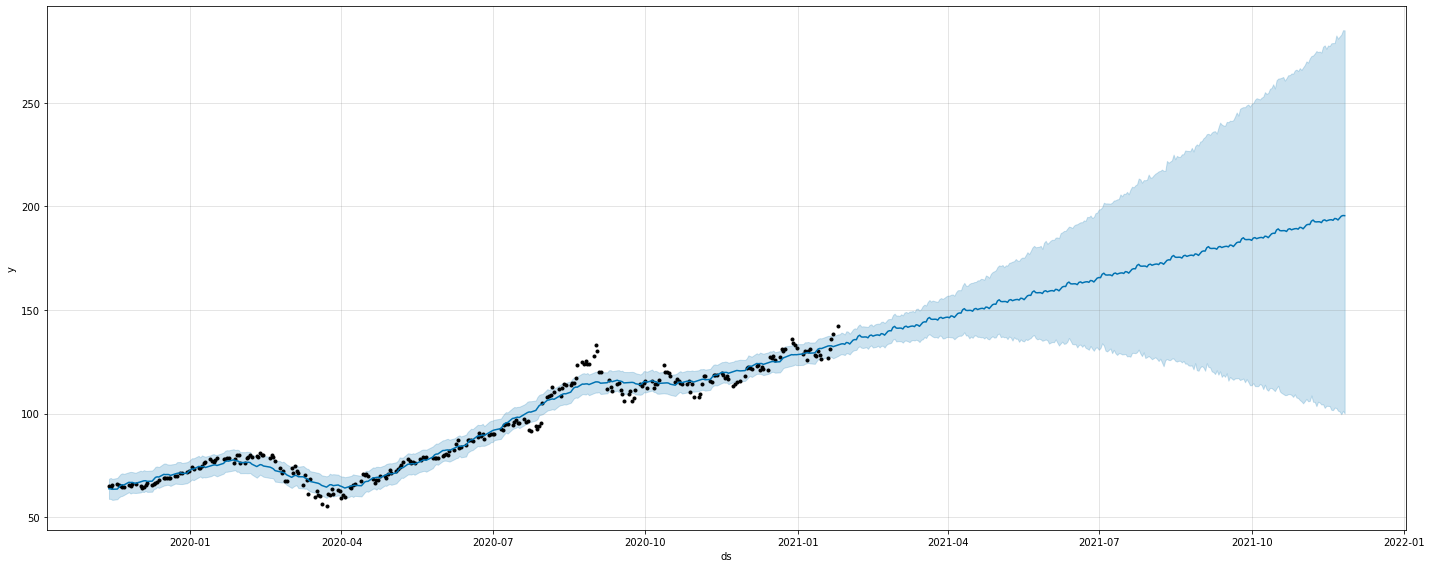

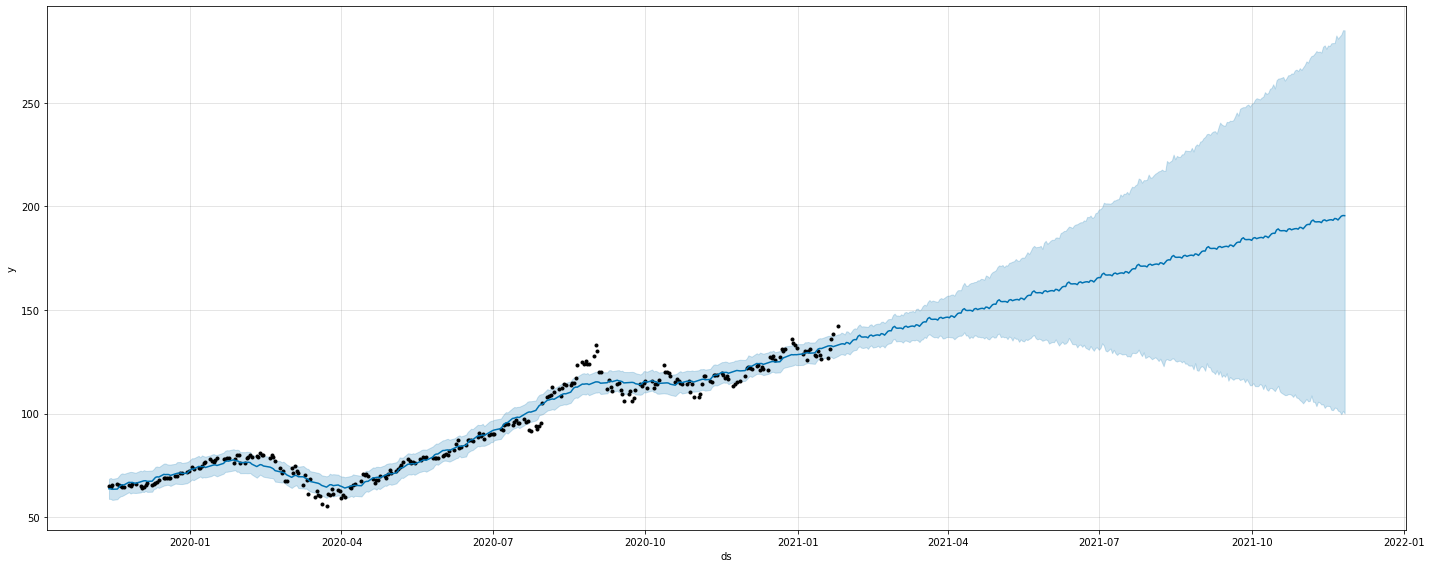

In [41]:
fig1= m.plot(prediction,figsize=(20,8))
fig1

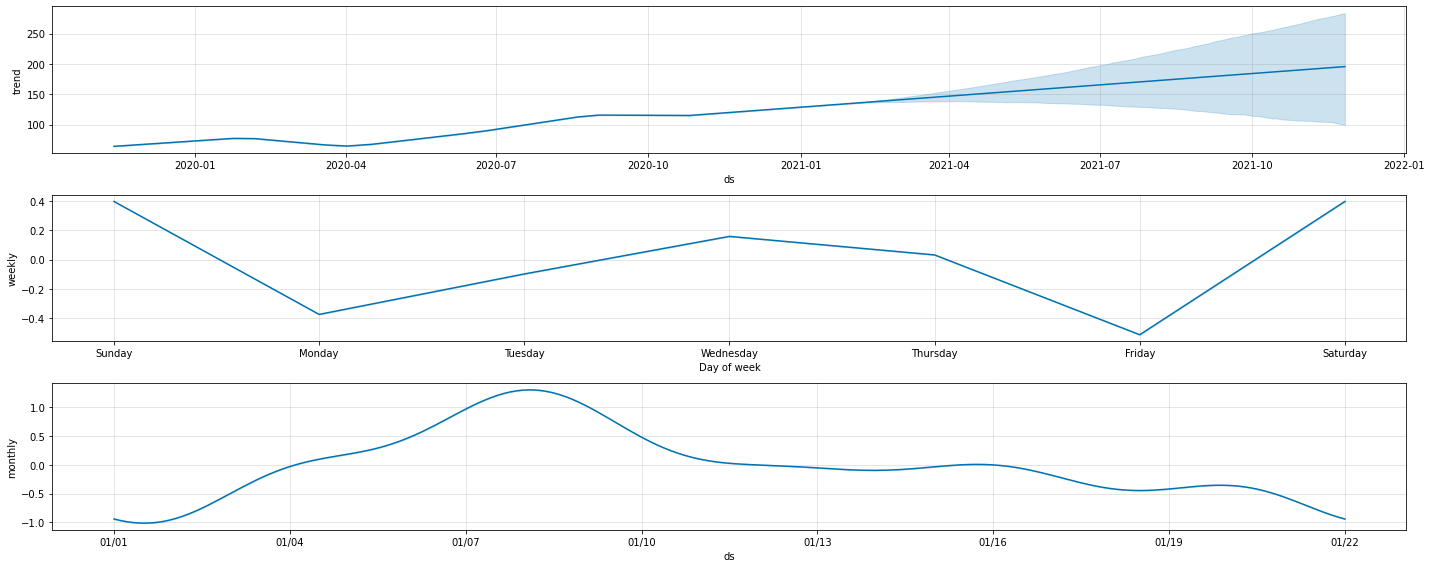

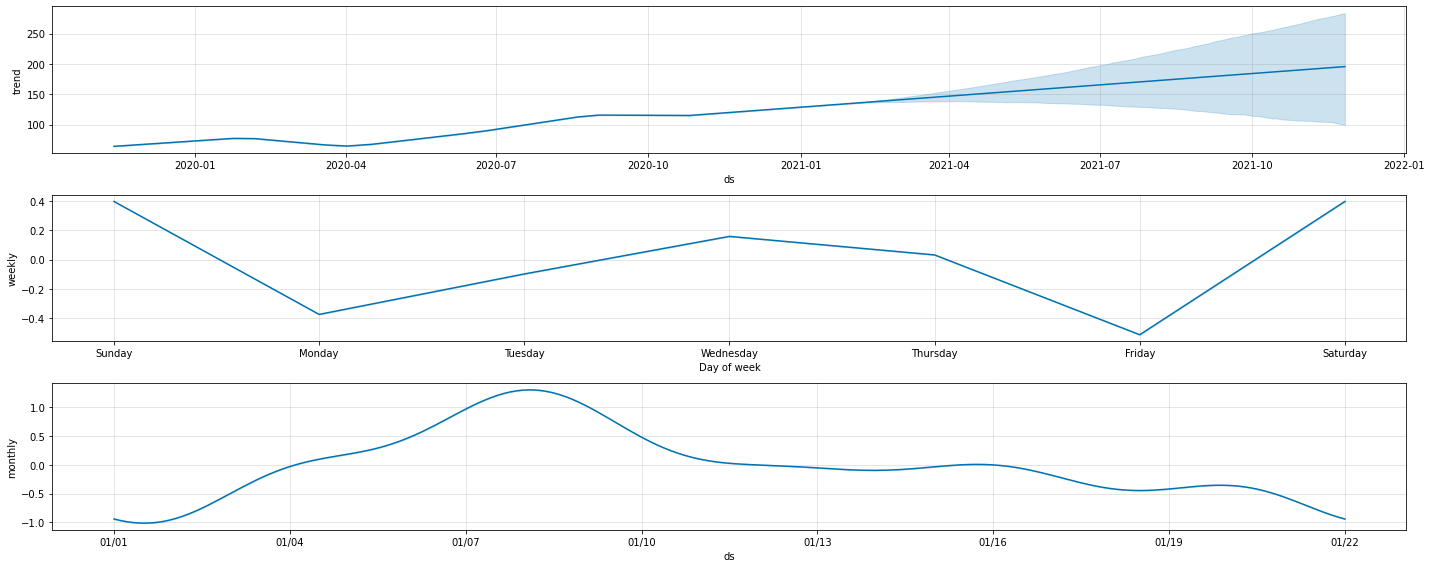

In [42]:
m.plot_components(prediction,figsize=(20,8))

In [48]:
#prediction.columns
prediction.count()

ds                            606
trend                         606
yhat_lower                    606
yhat_upper                    606
trend_lower                   606
trend_upper                   606
additive_terms                606
additive_terms_lower          606
additive_terms_upper          606
monthly                       606
monthly_lower                 606
monthly_upper                 606
weekly                        606
weekly_lower                  606
weekly_upper                  606
multiplicative_terms          606
multiplicative_terms_lower    606
multiplicative_terms_upper    606
yhat                          606
dtype: int64

In [67]:
prediction_segment =prediction[['ds','yhat_lower','yhat_upper','yhat']]

In [52]:
prediction_segment.tail()

,ds,yhat_lower,yhat_upper,yhat
601,2021-11-22,101.391196,280.955529,193.435485
602,2021-11-23,101.041319,281.961745,194.372112
603,2021-11-24,99.667655,282.883585,195.292235
604,2021-11-25,101.365582,285.015184,195.585032
605,2021-11-26,100.071932,284.947414,195.515908


In [53]:
merged_test_predict_segment=df_test1.merge(prediction_segment,on='ds',how='left')

In [55]:
#conveting  ds into timestemp
merged_test_predict_segment['ds']=pd.to_datetime(merged_test_predict_segment['ds'])
#del merged_test_predict_segment['index']

#set ds as index
merged_test_predict_segment =merged_test_predict_segment.set_index('ds')


In [ ]:
merged_test_predict_segment.rename(columns={'date':'y'},inplace=True)
merged_test_predict_segment.head()

,y,yhat_lower,yhat_upper,yhat
ds,,,,
2021-01-22,138.22,127.178223,137.620058,132.295557
2021-01-25,142.04,127.919572,138.444099,133.097771
2021-01-26,142.28,128.317088,137.919409,133.398003
2021-01-27,141.19,128.640493,138.736095,133.628985
2021-01-28,136.25,128.625852,138.559994,133.697369


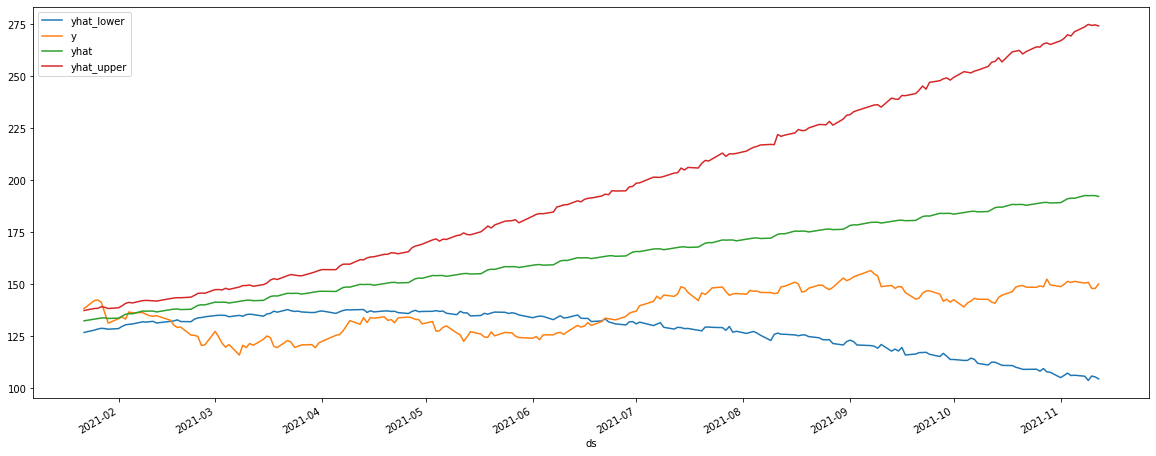

In [59]:
merged_test_predict_segment[['yhat_lower','y','yhat','yhat_upper']].plot(figsize=(20,8))

In [57]:
merged_test_predict_segment.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 206 entries, 2021-01-22 to 2021-11-12
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   y           206 non-null    float64
 1   yhat_lower  206 non-null    float64
 2   yhat_upper  206 non-null    float64
 3   yhat        206 non-null    float64
dtypes: float64(4)
memory usage: 8.0 KB


[Text(0, 0.5, 'APPLE STOCK PRICE'),
 Text(0.5, 0, 'DATE'),
 Text(0.5, 1.0, 'APPLE PRICE- ACTUAL VS PREDICTED')]

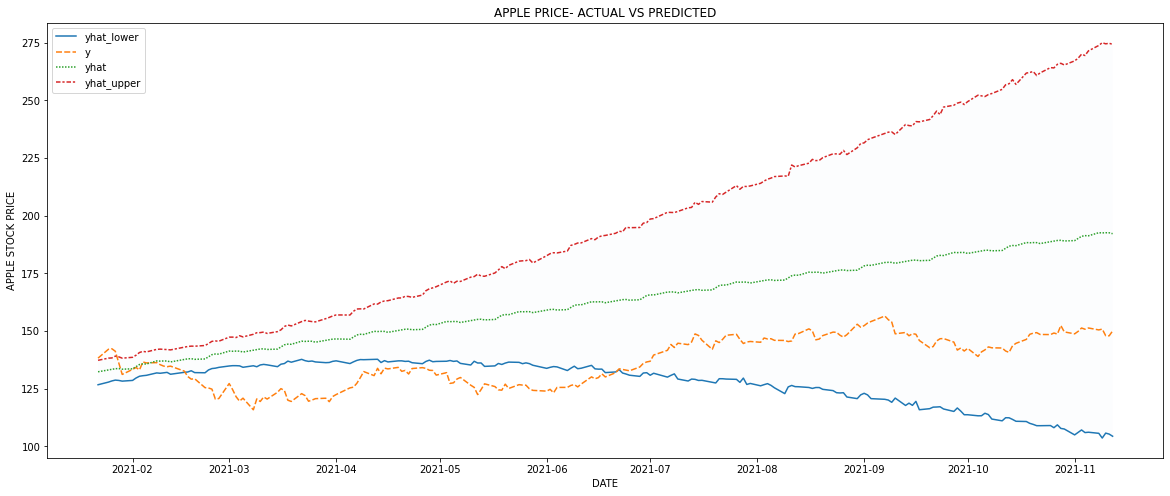

In [60]:
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(20,8))
ax=sns.lineplot(data=merged_test_predict_segment[['yhat_lower','y','yhat','yhat_upper']])
ax.fill_between(merged_test_predict_segment.index
                ,merged_test_predict_segment.yhat_lower,
                merged_test_predict_segment.yhat_upper,
                alpha=.01)
ax.set(title='APPLE PRICE- ACTUAL VS PREDICTED',xlabel='DATE',ylabel='APPLE STOCK PRICE')

In [ ]:
#cross_validation

# from fbprophet.diagnostics import  cross_validation,performance_metrics

# cv=cross_validation(m,initial='25 days',horizon='300 days',period='30 days')
# perf_cv=performance_metrics(cv)
# perf_cv.head()

In [ ]:
# cv.head()

In [ ]:
# cv[['yhat_lower','y','yhat_upper']].plot()

In [ ]:
# from fbprophet.plot import plot_cross_validation_metric
# fig_cv=plot_cross_validation_metric(cv,metric='mape')

ARIMA MODEL

In [75]:
!pip install pmdarima

In [74]:
import pmdarima as pm